# Mn-Salinity relationship


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import pickle
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

%matplotlib notebook

###### Parameters:

In [34]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

results_folder = '/data/brogalla/run_storage/ref-spin-up2-ice2/'
year  = 2002
month = 8

# colours:
obs_CB     = '#b23333'
obs_CAA    = '#d89999'
mod_CB     = '#006f99'
mod_CAA    = '#99c5d6'
land_color = "#8b7765"

###### Load files:

In [35]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [36]:
mask     = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh_zgr10.nc')
tmask    = np.array(mask.variables['tmask'][0,:,:,:])
Z_masked = np.ma.masked_where((tmask > 0.1), tmask) 

Model results

In [37]:
c = nc.Dataset(results_folder+'ANHA12_EXH006_'+str(year)+'_monthly.nc', 'r')

lat_model    = np.array(c.variables['nav_lat'])
lon_model    = np.array(c.variables['nav_lon'])
depths_model = np.array(c.variables['deptht'])
mn_dis1      = np.array(c.variables['dissolmn'])

In [38]:
S_file  = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m08d28.nc')
S_model = np.array(S_file.variables['vosaline'])

Observations

In [39]:
Mn_data  = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Mn_Integrated_Data_UBC-UVic_4-17-19.csv')

dMn_BB1  = Mn_data['BB1'].dropna()[1:].astype('float'); dMn_BB2 = Mn_data['BB2'].dropna()[1:].astype('float');
dMn_BB3  = Mn_data['BB3'].dropna()[1:].astype('float'); dMn_CB1 = Mn_data['CB1'].dropna()[1:].astype('float');
dMn_CB2  = Mn_data['CB2'].dropna()[1:].astype('float'); dMn_CB3 = Mn_data['CB3'].dropna()[1:].astype('float');
dMn_CB4  = Mn_data['CB4'].dropna()[1:].astype('float'); dMn_CAA1 = Mn_data['CAA1'].dropna()[1:].astype('float');
dMn_CAA2 = Mn_data['CAA2'].dropna()[1:].astype('float'); dMn_CAA3 = Mn_data['CAA3'].dropna()[1:].astype('float');
dMn_CAA4 = Mn_data['CAA4'].dropna()[1:].astype('float'); dMn_CAA5 = Mn_data['CAA5'].dropna()[1:].astype('float');
dMn_CAA6 = Mn_data['CAA6'].dropna()[1:].astype('float'); dMn_CAA7 = Mn_data['CAA7'].dropna()[1:].astype('float');
dMn_CAA8 = Mn_data['CAA8'].dropna()[1:].astype('float'); dMn_CAA9 = Mn_data['CAA9'].dropna()[1:].astype('float');

In [40]:
Pb_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons      = Pb_data['station lon'].astype('float').dropna().values
lats      = Pb_data['Station lat'].astype('float').dropna().values

In [41]:
S_obs    = np.arange(22, 36, 1)
dmn_obs1 = -0.601*S_obs + 21.9 # CB
dmn_obs2 = -1.26*S_obs + 45.2  # CAA

##### Define functions:

In [42]:
def find_index_ANHA12_full(transect_lons, transect_lats, ANHA12_lon=mesh_lon, ANHA12_lat=mesh_lat):
    # input:   ANHA12_lon, ANHA12_lat       --- 2400x1632 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    if isinstance(transect_lons,float):
        i, j = ar.find_closest_model_point(transect_lons, transect_lats, ANHA12_lon, ANHA12_lat)
        transect_i = i
        transect_j = j
    else:
        for k in range(0,len(transect_lons)):
            i, j = ar.find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12_lon, ANHA12_lat)
            transect_i = np.append(transect_i, i)
            transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

In [43]:
def find_index_ANHA12_sub(transect_lons, transect_lats, ANHA12sub_lon=lon_model, ANHA12sub_lat=lat_model):
    # input:   ANHA12sub_lon, ANHA12sub_lat --- 570x600 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    
    if isinstance(transect_lons,float):
        i, j = ar.find_closest_model_point(transect_lons, transect_lats, ANHA12sub_lon, ANHA12sub_lat)
        transect_i = i
        transect_j = j
    else:
        for k in range(0,len(transect_lons)):
            i, j = ar.find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12sub_lon, ANHA12sub_lat)
            transect_i = np.append(transect_i, i)
            transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

In [44]:
def model_data(name, lons=lons, lats=lats, stn_names=stn_names, S_model=S_model):
    lon_station = lons[stn_names==name]
    lat_station = lats[stn_names==name]
    
    # Find station index
    model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
    model_i, model_j = find_index_ANHA12_full(lon_station, lat_station)
    model_i = int(model_i); model_j = int(model_j);
    model_stni = int(model_stni); model_stnj = int(model_stnj);
    
    print(model_stni, model_stnj)

    mn_ij1  = mn_dis1[8, 0, 0:17, model_stni, model_stnj]*10**9
    S_ij1   = S_model[0, 0:17, model_i, model_j]
    dmn_stn = np.ma.masked_where((tmask[0:17,model_i, model_j] < 0.1), mn_ij1)   
    S_stn   = np.ma.masked_where((tmask[0:17,model_i, model_j] < 0.1), S_ij1)   

    return dmn_stn, S_stn

##### Figure for Mn-S at evaluation stations

<IPython.core.display.Javascript object>


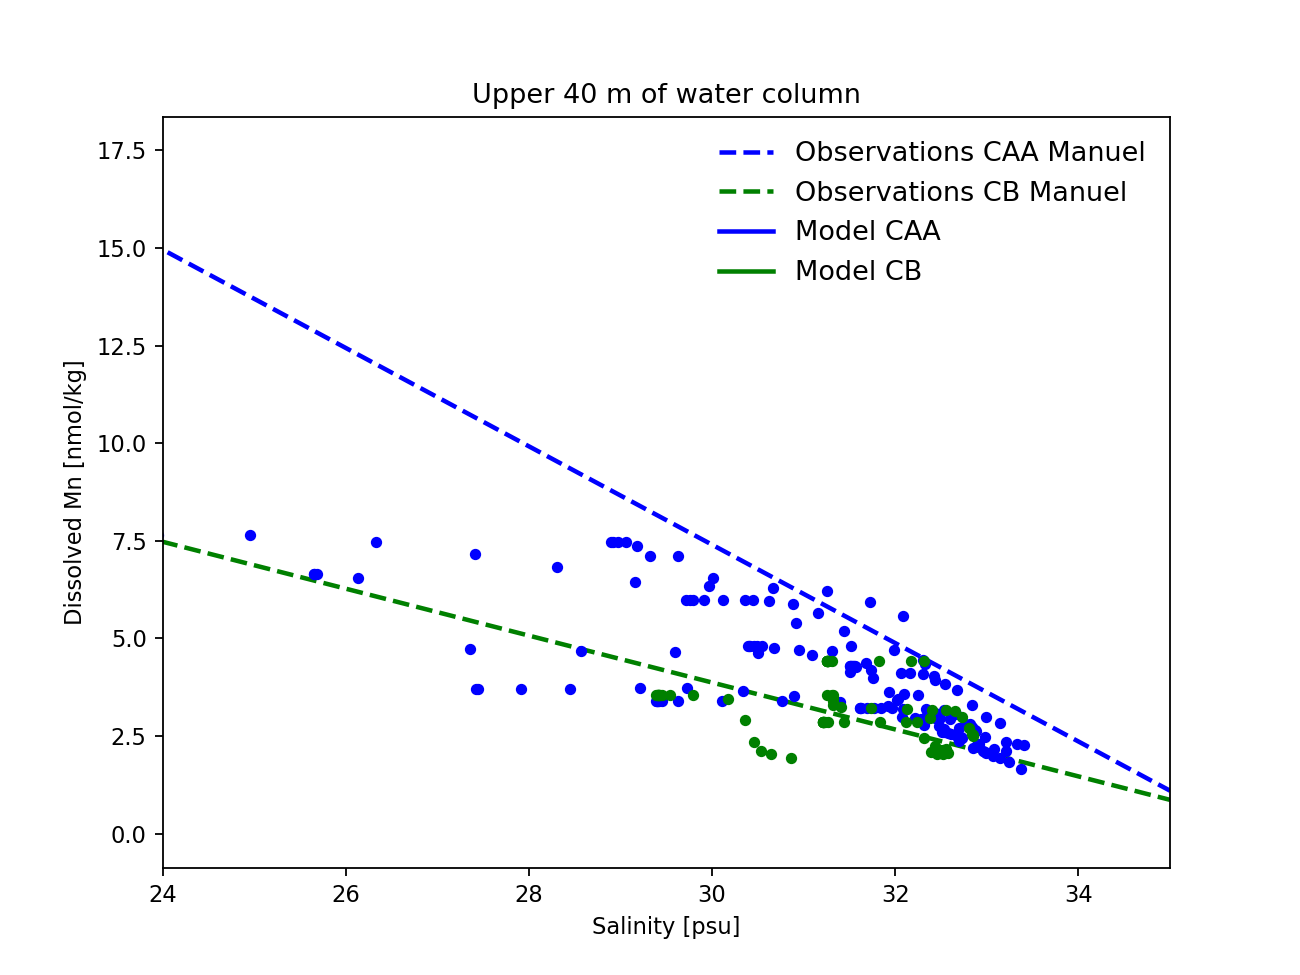

104 370
100 365
91 353
175 311
175 326
233 313
214 281
352 281
242 364
458 332
508 384
547 457
629 471


In [45]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(S_obs, dmn_obs1, '--g', linewidth=2.0)
ax.plot(S_obs, dmn_obs2, '--b', linewidth=2.0)

names = ['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7','CAA8','CAA9', \
            'CB1','CB2','CB3','CB4']
for name in names:
    dmn_stn, S_stn = model_data(name)
    if name[0:3] == 'CAA':
        ax.plot(S_stn, dmn_stn, '.b', markersize=8)
    else:
        ax.plot(S_stn, dmn_stn, '.g', markersize=8)

ax.plot([0,0],[0,0], '--b', linewidth=2.0, label='Observations CAA Manuel')
ax.plot([0,0],[0,0], '--g', linewidth=2.0, label='Observations CB Manuel')
ax.plot([0,0],[0,0], '-b', linewidth=2.0, label='Model CAA')
ax.plot([0,0],[0,0], '-g', linewidth=2.0, label='Model CB')

ax.set_title('Upper 40 m of water column')
ax.set_xlim([24, 35])
ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Dissolved Mn [nmol/kg]')
ax.legend(frameon=False, fontsize=12)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/salinity_dmn.png')

##### Figure for Mn-S in the full domain

Seperate Canada Basin and CAA

In [46]:
x_ind = np.arange(1700, 2100, 1)
y_ind = (-7/8)*x_ind + 1487.5 + 800

CB_indx = []
CB_indy = []

for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2180,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)

Separate salinity and mn results based on these definitons.

In [47]:
CB_S  = np.empty((50,len(CB_indx)))
CB_mn = np.empty((50,len(CB_indx)))

for i in range(0,len(CB_indx)):
    CB_S[:,i]  = S_model[0,:,int(CB_indx[i]),int(CB_indy[i])]
    CB_mn[:,i] = mn_dis1[8,0,:,int(CB_indx[i]-imin),int(CB_indy[i]-(jmin+1))]*10**9

In [48]:
S_PML  = S_model[0,0:17,imin:imax:5,jmin:jmax:5].flatten()
mn_PML = mn_dis1[8,0,0:17,::5,::5].flatten()*10**9

<IPython.core.display.Javascript object>


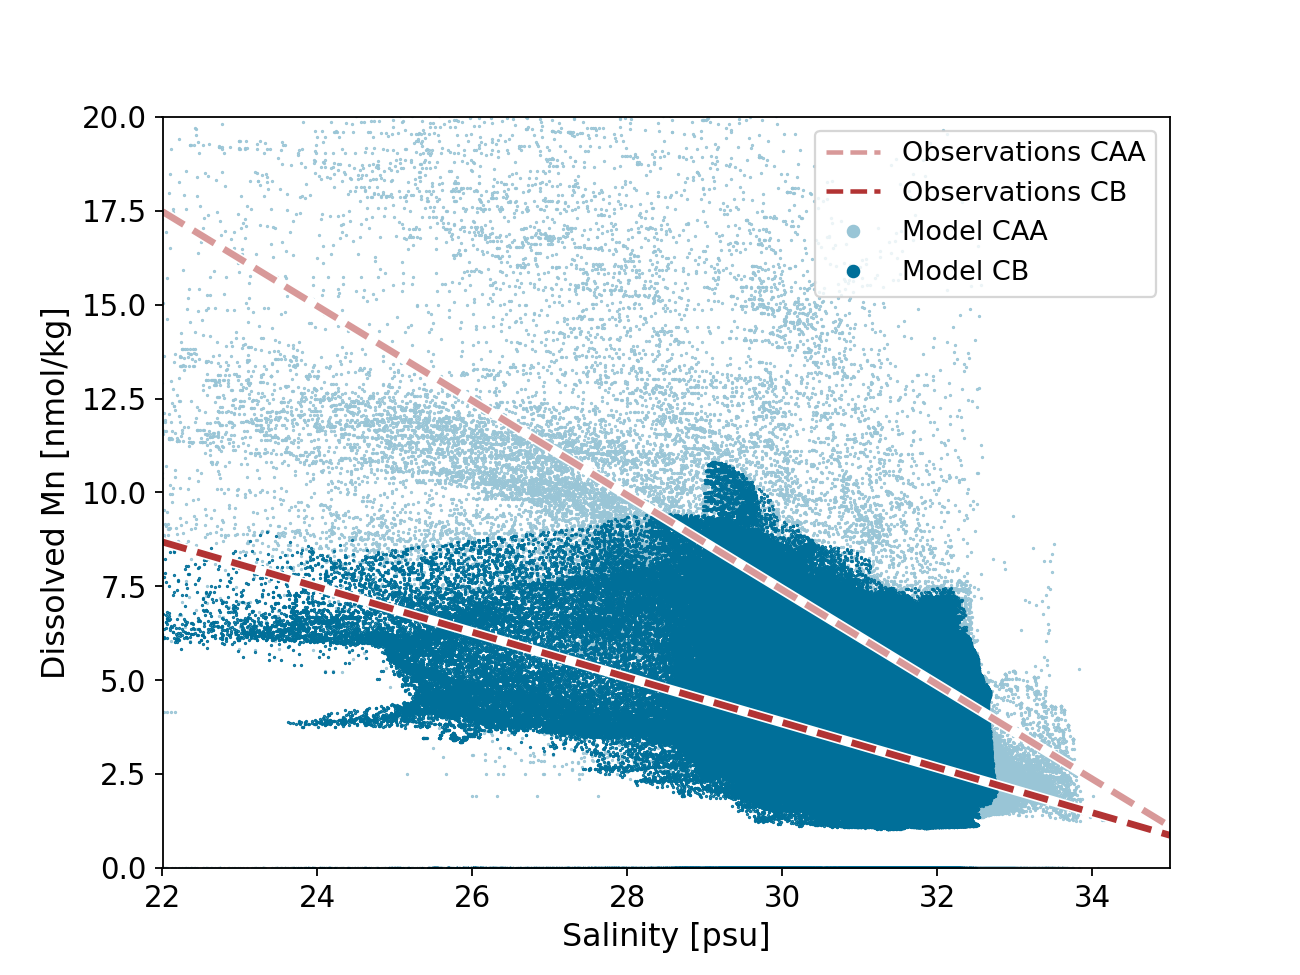

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

# Model results:
ax.plot(S_PML       , mn_PML       , '.', color=mod_CAA, markersize=0.9)
ax.plot(CB_S[0:17,:], CB_mn[0:17,:], '.', color=mod_CB , markersize=0.9)

# Observations
ax.plot(S_obs, dmn_obs1, 'w', linewidth=4.5)
ax.plot(S_obs, dmn_obs2, 'w', linewidth=4.5)
ax.plot(S_obs, dmn_obs1, '--', color=obs_CB , linewidth=3.0)
ax.plot(S_obs, dmn_obs2, '--', color=obs_CAA, linewidth=3.0)
    
# Reference lines    
ax.plot([0,0],[0,0], '--', c=obs_CAA, linewidth=2.0, label='Observations CAA')
ax.plot([0,0],[0,0], '--', c=obs_CB , linewidth=2.0, label='Observations CB')
ax.plot([0,0],[0,0], '.' , c=mod_CAA, markersize=10, label='Model CAA')
ax.plot([0,0],[0,0], '.' , c=mod_CB , markersize=10, label='Model CB')

ax.set_xlim([22, 35])
ax.set_ylim([0, 20])
ax.set_xlabel('Salinity [psu]', fontsize=14)
ax.set_ylabel('Dissolved Mn [nmol/kg]', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=13)

ax.legend(frameon=True, fontsize=12)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/R1-MnS-evaluation-20200327.png', bbox_inches='tight', dpi=300)

##### Figure of separation of CB and CAA

<IPython.core.display.Javascript object>


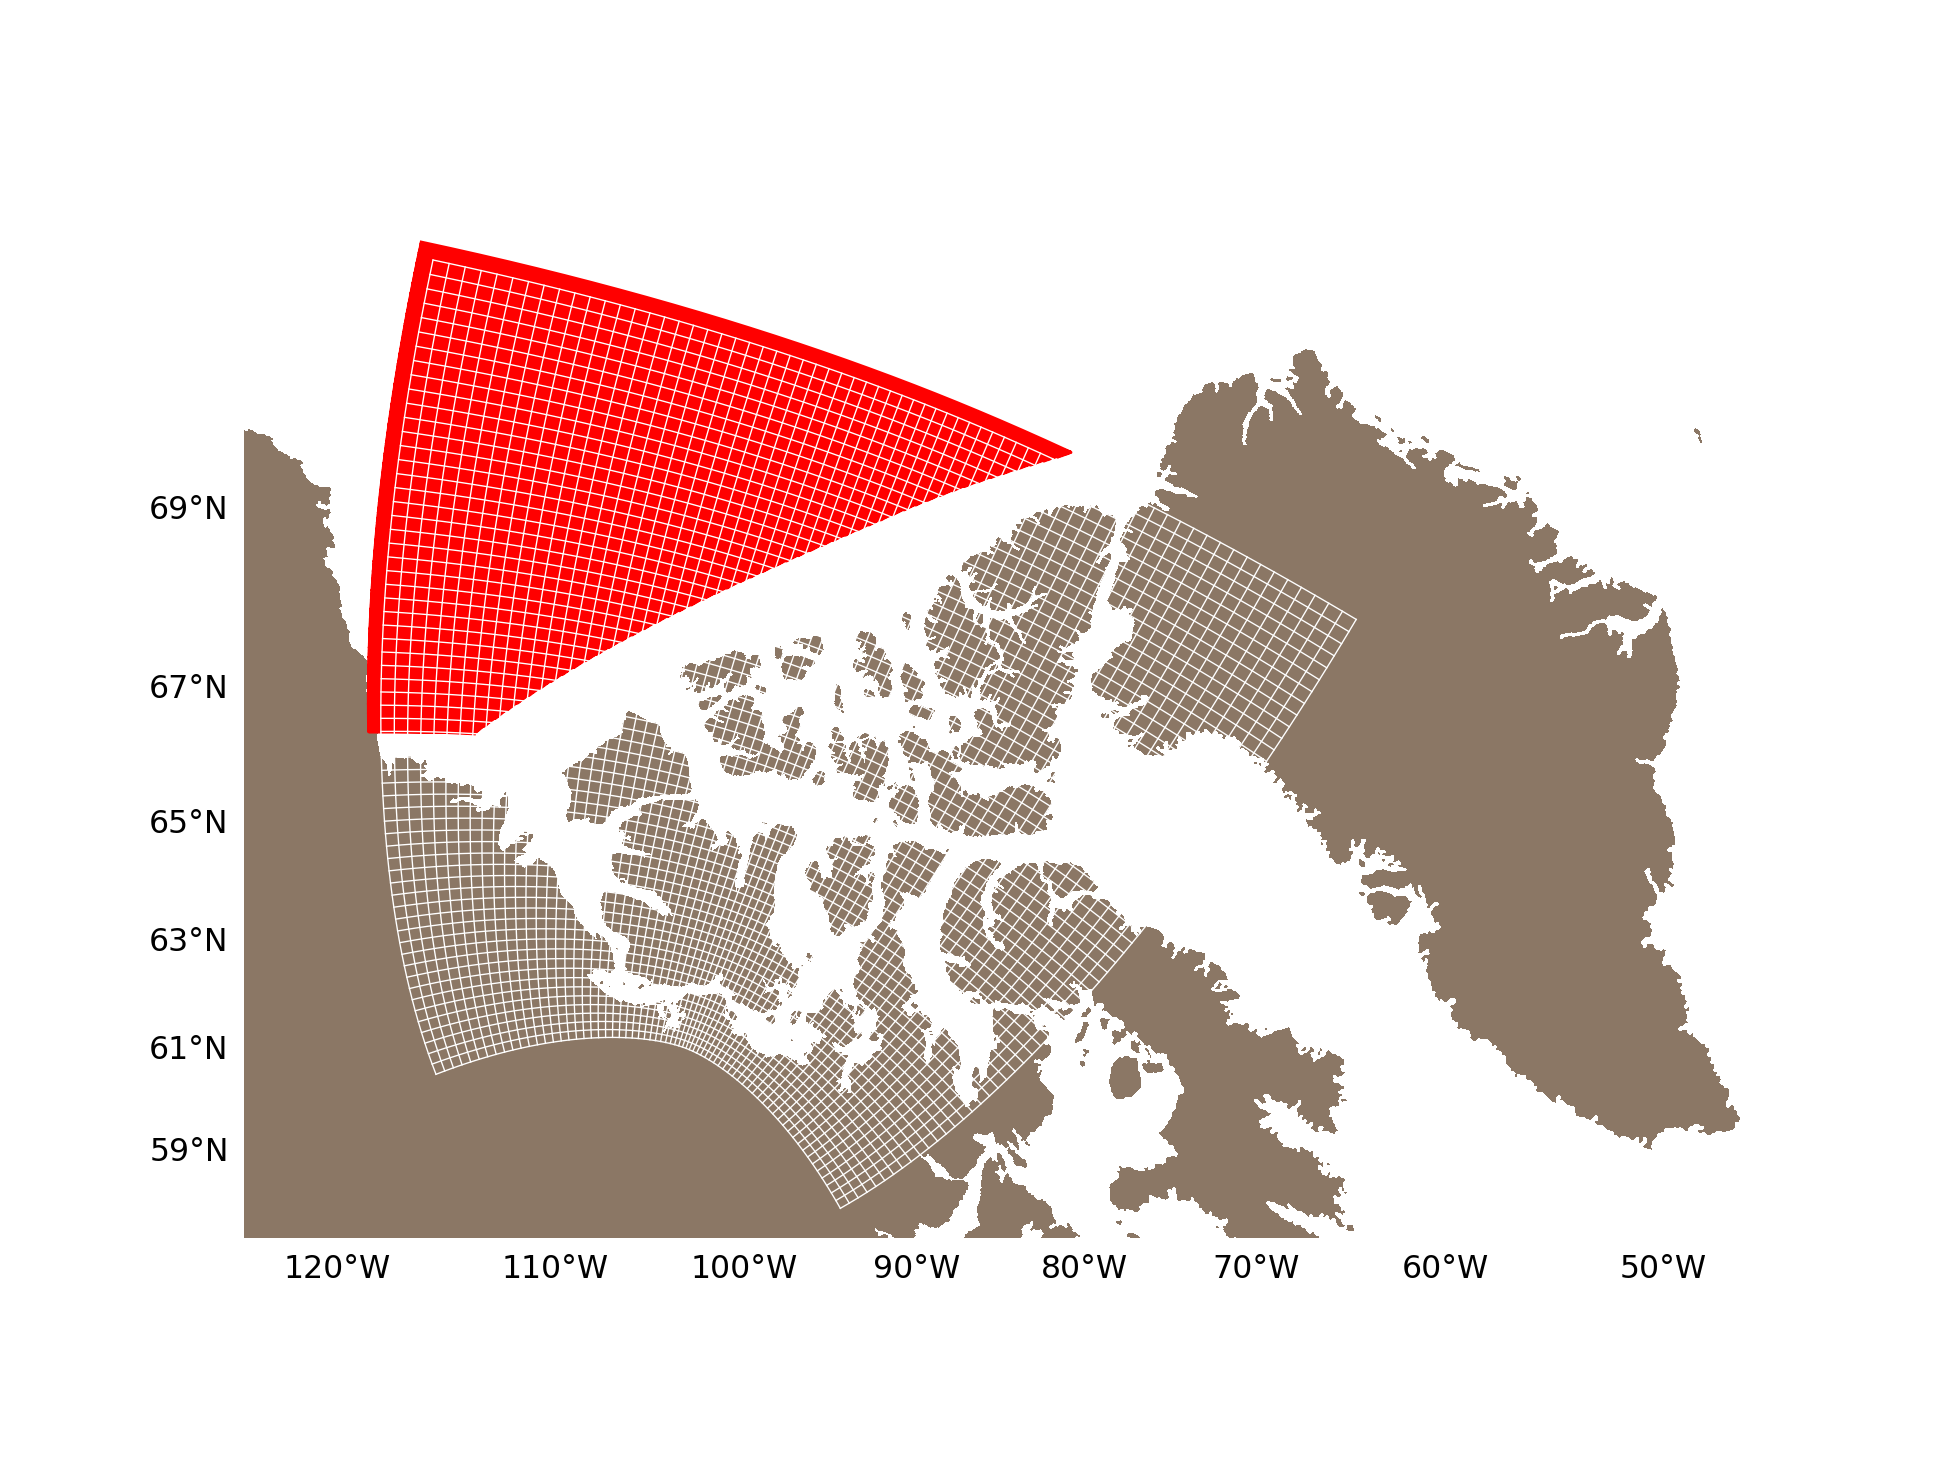

In [19]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

CB_lons = []
CB_lats = []

for i in range(0,len(CB_indx)):
    CB_lons = np.append(mesh_lon[int(CB_indx[i]),int(CB_indy[i])], CB_lons)
    CB_lats = np.append(mesh_lat[int(CB_indx[i]),int(CB_indy[i])], CB_lats)

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 
res=10
proj1.plot(x_sub[imin:imax:res,jmin:jmax:res], y_sub[imin:imax:res,  jmin:jmax:res], 'w-', lw=0.6, zorder=3);
proj1.plot(x_sub[imin:imax:res,jmin:jmax:res].T, y_sub[imin:imax:res,jmin:jmax:res].T, 'w-', lw=0.6, zorder=3);

x_CB, y_CB = proj1(CB_lons, CB_lats)
proj1.plot(x_CB, y_CB, '-r')